## Before submitting:

1. Fill your name and studet id number below:

2. Please submit only the `*.pdf` file.

3. Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. 


In [1]:
STUDENT_NAME = "Dennis Grinwald"
STUDENT_ID = "406516"

# Exercise Sheet 1: Brain Computer Interface

This first exercise sheet is about two common approaches in BCI for processing and analysing of the EEG (electroencephalogram) data. 

## 1. Event-related potentials (20 P)

__1.1__ Please give at least two examples where the BCI in your opinion can be applied in the future. __(10 P)__

1. Communication Interface between "locked-in" patients, who are limited in their ability of interacting with their environment 
2. Decoding mental states of patients, that for instance suffer under some sort of psychological disorder, in order to offer a better medical treatment.

__1.2__ What are the advantages and the disadvantages of the non-invasive BCI methods. __(5 P)__  

### Advantages: 
- No need for complex and dangerous surgery is needed
- Faster procedure to get starting
- No need to bother as hard about legal issues
- low costs

### Disadvantages:
- Besides collecting the wanted data, non-invasive BCI methods are drawn to collect a lot of "noisy" data aswell, which naturally makes it hard to analyse experiment data -> not as accurate as Invasive-BCI

__1.3__ Describe with your own words what does the Motor Imagery Classification task mean. __(5 P)__

Motor Imagery is the process of mentally preparing for an actual movement of the body, not restricted on which part of the body, by simply thinking about it.

This process can be recorded via a BCI. A person's(wearing BCI) intent of moving can be recorded and analyzed before the actual movement happenend.

## 2. Common Spatial Pattern (15 P)

### Given an EEG data as a tensor $E \in \mathbb{R}^{(T \times K \times M)}$, where
* $T$ is the number of trials
* $K$ is the number of channels
* $M$ is the number of samples within each trial

#### $E_n$ denotes the EEG data for $n^{th}$ trial. Then $E_n \in \mathbb{R}^{(K \times M)}$

__2.1__ Show that the CSP optimization problem can be solved as __generalized eigenvalue problem__.

<h3 align="center"> $\mathcal{L}(W)  = \max_w  \text{tr}\Big( W^{\top}\Sigma_1 W\Big)$,</h3> 

<h3 align="center"> $\text{subject to} \quad W^{\top}(\Sigma_1 + \Sigma_2) W = I$, </h3>

where
<h1> 
$$
\Sigma_1 =  \mathbb{E}_{E_n \in \{ \text{class 1}\}} \Big\{{E_n E_n^{\top}}/{\text{tr}(E_n E_n^{\top})}\Big\}
$$
</h1>

and
<h1> 
$$
\Sigma_2 =  \mathbb{E}_{E_n \in \{ \text{class 2}\}} \Big\{{E_n E_n^{\top}}/{\text{tr}(E_n E_n^{\top})}\Big\} \quad n = \overline{1..N}.
$$
</h1>

# Solution
From the objective and it's constraints we derive the following Lagrangian Function:

$L(W,\Lambda) = \text{tr}\Big(W^{\top}\Sigma_1 W\Big)I - (W^{\top}(\Sigma_1 + \Sigma_2) W - I)\Lambda$

For optimizing the Lagrangian we simply set it's gradient, wrt. $W$ to equal $0$:

$\nabla_{W} L(W,\Lambda) \stackrel{!}{=} 0 \Leftrightarrow \Sigma_1 W + \Sigma_1^{\top} W - 2(\Sigma_1 + \Sigma_2) W \Lambda = 0$ 

Since $\Sigma_1^{\top} = \Sigma_1$, we derive the following equation:
$2 \Sigma_1 W = 2(\Sigma_1 + \Sigma_2) W \Lambda \Leftrightarrow \Sigma_1 W = (\Sigma_1 + \Sigma_2) W \Lambda$

By defining: $\Sigma_1 = A$ and $(\Sigma_1 + \Sigma_2) = B$ we derive the generalized eigenvalue problem: 

$AW = BW\Lambda$

## 3. Perform CSP Analysis on Motor Imagery Data (60 P)

__3.1__ Load the bandpass filtered EEG dictionary data from compressed *.npz* file called *EEG.npz*. __(5 P)__

Where 
* dictionary keys are __*['L', 'E']*__
* __$E$__:   a 3D array of segmented signals (samples x channels x trials) *$(M\times K \times T)$*
* __$L$__: a 1D array with corresponding class labels (0, 1)

In [2]:
import numpy as np
from numpy import load
from numpy import reshape
from scipy.linalg import eigh

data = load("/home/dg/Dropbox/TUB/SoSe19/ML_SC/hw1/EEG.npz")

E = data["E"]
L = data["L"]

M = E.shape[0]
K = E.shape[1]
T = E.shape[2]

class0 = E[:,:,L==0]
class1 = E[:,:,L==1]

In [3]:
'''
Just checking the dimensions here
'''
print(class0.shape)
print(E.shape)

(300, 51, 100)
(300, 51, 200)


In [4]:
E = np.transpose(E,(1,0,2))
print(E.shape)

(51, 300, 200)


__3.2__ Reshape and flatten the $E$ tensor to a matrix with dimensions *$(K \times M*T)$*.

Compute covariance matrices $(\Sigma_0$ and $ \Sigma_1)$ for corresponding classes from the $L$ array. __(5 P)__

In [5]:
epo = np.array([E[i,:,:].flatten() for i in range(K)])
print(epo.shape)

(51, 60000)


In [6]:
### Computing the Variances
### Shape class0 & class1: 300x51x100
cov0 = 0
for row in class0.transpose((2,1,0)):
    tmp_cov = np.dot(row,row.T)
    cov0 += tmp_cov / np.trace(tmp_cov)
cov0 /= class0.shape[2]
sig0 = cov0
    
cov1 = 0
for row in class1.transpose((2,1,0)):
    tmp_cov = np.dot(row,row.T)
    cov1 += tmp_cov / np.trace(tmp_cov)
cov1 /= class1.shape[2]
sig1 = cov1

print(sig0.shape)
print(sig1.shape)

(51, 51)
(51, 51)


__3.3__ Solve the generalized eigenvalue problem in order to get __common spatial patterns $W_{csp}$__.   __(5 P)__

In [7]:
'''
np.linalg.eigh():
w : (…, M) ndarray
The eigenvalues in ascending order, each repeated according to its multiplicity.
v : {(…, M, M) ndarray, (…, M, M) matrix}
The column v[:, i] is the normalized eigenvector corresponding to the eigenvalue w[i]
'''
Lam, W = eigh(sig0,(sig0+sig1))
print(Lam.shape)

(51,)


__3.4__ Plot explained variance (eigenvalue) vs. egenvalue index for the CSPs for each class. Show a legend for every class curve. __(10 P)__
 

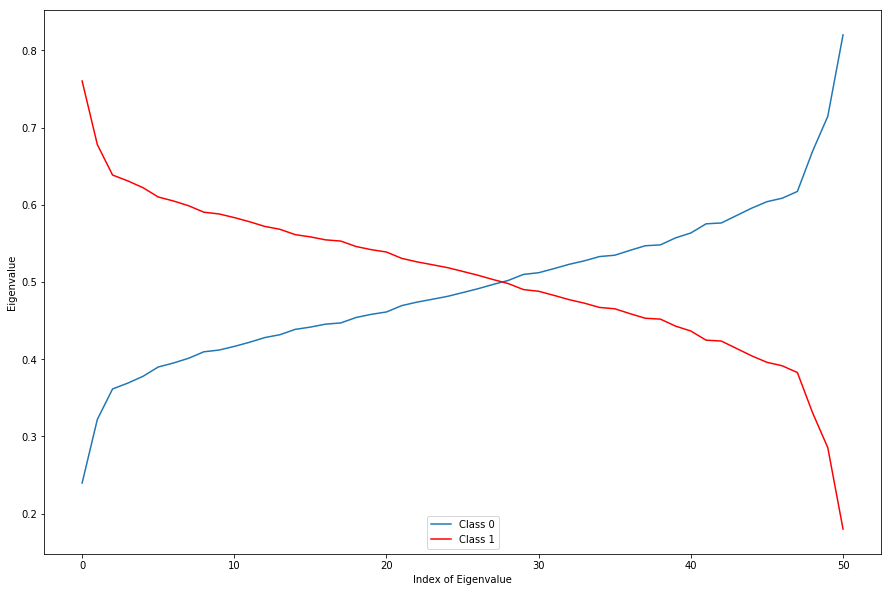

In [8]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
plt.rcParams['savefig.dpi'] = 90

fig = plt.figure(figsize=(15,10))

plt.plot(range(len(Lam)),Lam,label="Class 0")
plt.plot(range(len(Lam)),1-Lam,color="r",label="Class 1")
plt.xlabel("Index of Eigenvalue")
plt.ylabel("Eigenvalue")
plt.legend(loc="lower center")

__3.5__ Project flatten *epo* matrix using common spatial patterns $W_{csp}$ from first three and last three eigenvalue component in order to get filtered signal matrix $S \in \mathbb{R}^{(2*3 \times M*T)}$. 

Reshape the signal matrix to a 3-dimensional tensor with a shape $(2*3 \times M \times T)$. __(5 P)__

In [9]:
#W_csp = np.column_stack([W[:,0:3],W[:,48:51]]) 
W_csp = np.hstack([W[:,0:3],W[:,48:51]]) 
print(W_csp.shape)

(51, 6)


In [10]:
S = np.dot(W_csp.T,epo)
print(S.shape)

(6, 60000)


In [11]:
S = np.reshape(S,(6,M,T))
print(S.shape)

(6, 300, 200)


__3.6__ Compute the feature matrix $X \in \mathbb{R}^{(6 \times T)}$ __(5 P)__,

where
 <h2 align = "center">   $X_i = \log \Big( \frac{var[s_i(t)]}{\sum_{i=1}^d var[s_i(t)]} \Big), \quad i = \overline{1..6}, \quad t = \overline{1..T}$ </h2> 

In [12]:
X = np.var(S,axis=1)
X /= np.sum(X,0)
X = np.log(X)

# Mean center the data
X -= np.mean(X,1)[:,None]

print(X.shape)

(6, 200)


__3.7__ Perform dimensionality reduction on the feature matrix $X$ to a 2-dimensional space using Singular Value Decomposition. __(10 P)__

This step is required to get lower dimensional feature representation which can be plottet at the end. 

$X_{low} \in \mathbb{R}^{(2\times T)}$

In [13]:
### Extract Eigenvectors,Eigenvalues from matrix
### U = 6x6 , S = 6x300, VH = 200x200

U, Sig, VH = np.linalg.svd(X.T,full_matrices=False)

print(U.shape)
print(Sig.shape)
print(VH.shape)

(200, 6)
(6,)
(6, 6)


In [14]:
### SAME RESULTS AS FOR PCA LIBRARY ###
X_low = np.dot(X.T,VH.T[:,0:2])

print(X_low.shape)

(200, 2)


__3.8__ Plot for each trial and the corresponding class label the low-dimenstional feature value representation. __(5 P)__

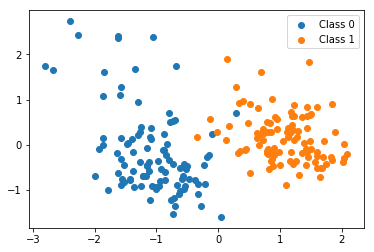

In [15]:
c0 = X_low[L==0,:]
c1 = X_low[L==1,:]
plt.scatter(c0[:,0],c0[:,1],label="Class 0")
plt.scatter(c1[:,0],c1[:,1],label="Class 1")
plt.legend()

__3.9__ Show that two classes are linearly separable with a metod like Linear Discriminative Analysis (LDA). And plot the class separation line. __(15 P)__

In [16]:
mu_1 = np.mean(c0,0)
mu_2 = np.mean(c1,0)

# 2x2
cov1 = np.dot(c0.T,c0)
cov2 = np.dot(c1.T,c1)
S_c = cov1 + cov2

### LDA algorithm
w = np.linalg.inv(S_c).dot(mu_1-mu_2)
C_0 = c0.dot(w)
C_1 = c1.dot(w)
boundary = w.dot((mu_1 + mu_2)/2)

print(cov1.shape)

(2, 2)


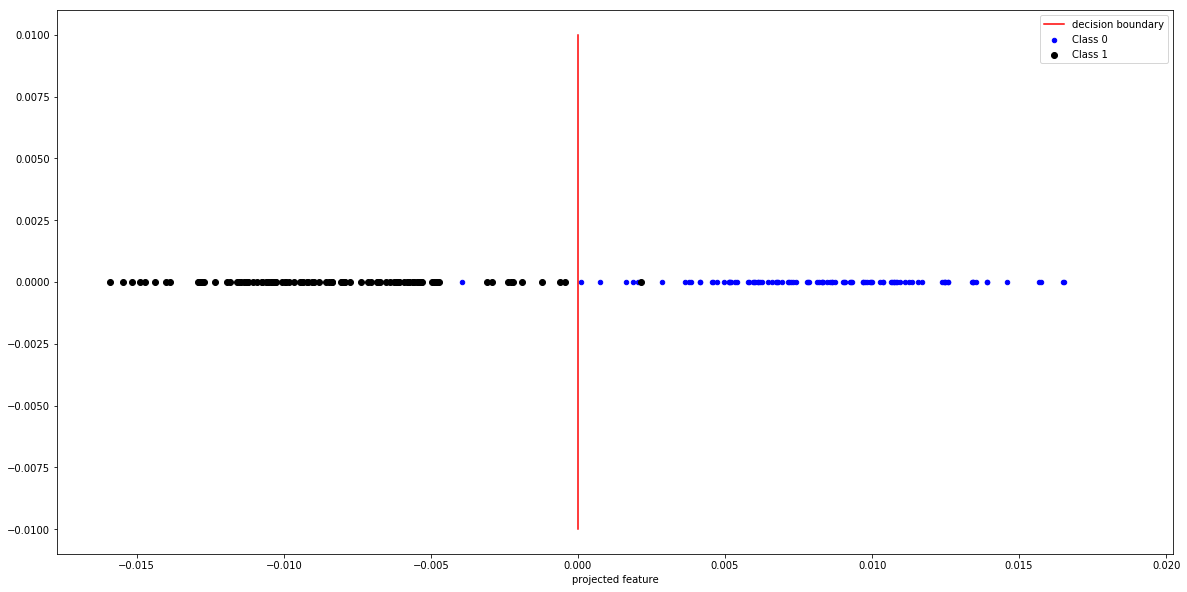

In [17]:
fig = plt.figure(figsize=(20,10))
plt.scatter(C_0,np.zeros(100), color = "b", label = "Class 0", s = 20)
plt.scatter(C_1,np.zeros(100), color = "k", label = "Class 1")
plt.xlabel("projected feature")
plt.plot(boundary*np.ones(2),np.array([-0.01,0.01]), color="red", label = "decision boundary")
plt.legend()